### Executive Summary

A notebook to simulate 1000 DRW light curves,  with 400 points each, spanning length of 2000 days,  with separation of 5 days , and input timescale of 100  days, so that the light curve is well within the unbiased regime ( much longer  than  10 timescales ) . We present the code used to simulate the light curves,  the results of using the code of Chelsea MacLeod to fit these light curves, and the results of fitting them with Celerite. 



* [Sec 1 : Simulating light curves](#sim_lc)
* [Sec 2 : Celerite fits](#celerite_fit)
    * [Sec 2.1 : Illustrating the fits](#illustrate)
* [Sec 3 : Compare Celerite and Chelsea](#compare)
    * [Sec 3.1 Save combined Celerite and Chelsea fit results](#save)


# Imports 

In [6]:
import numpy as np 
import os
import datetime
from itertools import product
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

import celerite
import numpy as np
import matplotlib.pyplot as plt
from celerite import terms
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column

Input properties for each of the 1000 light curves  : 

  $\tau_{in} = 100 $ days
   
  $\sigma_{in} = 0.2  $ mag

  $SF_{\infty} = 0.2*\sqrt{2} = 0.2828$ mag

length = $l= 20 \tau$

dt = 5 days 

random sampling  from a uniform distribution 

yerr = 0.001  mag 

400 points 

# Code to simulate light curves <a id='sim_lc'></a> 

These light curves were simulated with the following code :

In [ ]:
def sim_DRW_lightcurve(t,SFinf,tau,mean_mag):
    '''Simulate a DRW lightcurve for a given time series t, with parameters
       (SFinf, tau), and mean magnitude.
       Uses equations A4 and A5 in Kelly 2009 (see also MacLeod+10 sec 2.2).'''
    mu = mean_mag  # the input parameter : mean mag: make an alias 
    mag = np.zeros(len(t),dtype=np.float32) # initialize an array of empty values
    mag[0] = mean_mag # start from the mean magnitude 
    dt = np.diff(t) # an array of differences  t[i+1]-t[i]
    for i in range(1,len(t)):
        # calculate the mean 
        loc = np.exp(-dt[i-1]/tau)*mag[i-1] + mu*(1-np.exp(-dt[i-1]/tau))
        # calculate the variance 
        var = 0.5 * SFinf**2 * (1-np.exp(-2*dt[i-1]/tau))
        # draw the magnitude value from a Gaussian distribution
        # with a given mean and standard deviation ( = sqrt(variance))
        mag[i] = np.random.normal(loc=loc,scale=np.sqrt(var))
    return mag


def sampling(tau_in = 100, length=10, t_min=1, N_pts = None,  dt = 10 , 
                        regular=False, verbose=False):
    ''' A convenience function to return user-defined sampling 
    
    Input: 
    -------
    tau_in : input timescale (default: 100 days )
    length : length in terms of multiples of timescale (default: 10) 
    t_min : starting point of lightcurve (default : 1 )
    N_pts: if provided , then we choose the dt based on the number 
         of points desired. Otherwise the number of points is 
         calculated based on the desired spacing. 
    dt : interval between samplings, if regular = True, then 
        this is the exact interval,  otherwise we divide the 
        light curve length by dt to determine the number 
        of points 
    regular : boolean (True / False). Use regular sampling with dt, 
        or random sampling with Npts = floor(total_timespan / dt) ? 
        
    Returns:
    ---------
    t : sampling times 
    '''
    t_max = t_min + length*tau_in
    if regular : 
        # evenly spaced sampling within the chosen interval 
        if verbose: 
            print('Using regular sampling')
        if N_pts is None : 
            t = np.arange(t_min, t_max, dt)
        else : 
            t = np.linspace(t_min, t_max, N_pts)
    else :
        # random sampling with the chosen number of points ... 
        # The output is sorted
        if verbose: 
            print('Using random sampling')
        if N_pts is None : 
            N_pts= int(np.floor((t_max - t_min) / dt))
        t = np.sort(np.random.uniform(t_min, t_max, N_pts)) 
        
    return t

# general setup 
regular_sampling = False
yerr =  0.001 # mags 
tau_in = 100 # days 
length = 20 
sigma_in = 0.2 # mags 
SF_inf = sigma_in * np.sqrt(2)
dt = 5.0  # length * tau_in / dt = 400 = N_points 
N_iterations =  1000

# simulating the cadence and DRW sampled at 
# observed times ... 
t = sampling(tau_in = tau_in, length=length, regular=regular_sampling, dt=dt)
y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0)


# Celerite fitting  <a id='celerite_fit'></a>

In [ ]:
# Make a dir for the results 
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_Celerite_ZI_LC_fits',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)




In [20]:
# Take exactly the same light curves , and show that Celerite fitting is 
# reproducible

# use_bounds  = True
# prior = 'flat'

{'sigma_in': 0.2, 'tau_in': 100, 'sigma_bounds': [0.01, 1.0], 'tau_bounds': [1, 10000], 'yerr': 0.001, 'length': 20, 'dt': 0.625, 'regular_sampling': False}


In [158]:
# Fitting  : each light curve is fit with various settings : 
# [ new_prior,  flat_prior , exp_prior]
#t,y,yerr = lc['time'], lc['mag'], lc['err']

# we have decided to use the bounds since we found 
# having them does not affect much the results  
# and both Kozlowski et al. , and MacLeod's codes
# include some boundaries to avoid nonsensical results ... 
sigma_bounds = [0.001, 1.0]
tau_bounds = [1,10000]
    
       
# fitting procedure : 
# initialize the Gaussian Process  RealTerm kernel ... 
# it can be done once for all fittings ... 
kernel = terms.RealTerm(log_a = 2 * np.log(sigma_in) , 
                        log_c = np.log(1/tau_in))

DirIn = '../raw_data/DRWtestCeleriteZI/'
files = os.listdir(DirIn)

# initialize dictionaries to store the results  
results = {}
# define which priors we would like to try ... 
priors = ['flat', 'Jeff1', 'Jeff2']

for prior in  priors:
    results[prior] = {'sigma_fit':np.zeros(len(files), dtype=float),
                     'tau_fit':np.zeros(len(files), dtype=float),
                     's_sigma':np.zeros(len(files), dtype=float),
                     's_tau':np.zeros(len(files), dtype=float),
                     's_loga':np.zeros(len(files), dtype=float),
                     's_logc':np.zeros(len(files), dtype=float)}
    
for i in range(len(files)) :
    # print progress... 
    if (i % 100)== 0 : 
        print(i)
        
    # read in Zeljko's light curve 
    lc = Table.read(DirIn +files[i], format='ascii', names=['time', 'mag', 'err'] )    
    t,y,yerr = lc['time'], lc['mag'], lc['err']
    
    # call the model  with a chosen kernel instance 
    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)
    
    initial_params = gp.get_parameter_vector()

    for use_bounds, prior in product([True], priors):    
        if use_bounds : # use some custom boundaries 
            logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
            loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
            bounds = [loga_bounds, logc_bounds]
        else : # use the built-in boundaries (-inf : +inf )
            bounds = gp.get_parameter_bounds()

        if prior is 'flat' : 
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                return -gp.log_likelihood(y)

        if prior is 'Jeff1' : 
            def neg_log_like(params,y,gp):
                gp.set_parameter_vector(params)
                log_a = params[0]
                log_c = params[1]
                return -gp.log_likelihood(y) + (log_a / 2.0) - log_c
            
            
        if prior is 'Jeff2' :
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                log_a = params[0]
                log_c = params[1]
                #log_sigma = log_a / 2.0 
                #log_tau = - log_c
                return -gp.log_likelihood(y)  +0.5* (np.log(2) - log_c + log_a  )

        # this one is plain wrong 
        if prior is 'b' : 
            def neg_log_like(params,y,gp):
                gp.set_parameter_vector(params)
                log_a = params[0]
                log_c = params[1]
                log_sigma = log_a / 2.0 
                log_tau = - log_c
                sigma = np.exp(log_sigma)
                tau  = np.exp(log_tau)
                return -gp.log_likelihood(y) - np.log(1.0/sigma + 1.0/tau)

        # do the scipy optimize to find the maximum likelihood estimator 
        # for hyperparameters.... 
        #print('Using %s prior'%prior)
        r = minimize(neg_log_like, initial_params, 
                     method="L-BFGS-B", bounds=bounds, args=(y, gp))
        gp.set_parameter_vector(r.x)

        import numdifftools as nd

        def Wrap_neg_log_like(theta) : 
            return neg_log_like(theta, y, gp)

        Hfun = nd.Hessian(Wrap_neg_log_like, full_output=True)
        hessian_ndt, info = Hfun(r['x'])

        # standard deviation is the square of variance
        # note  : this error is the error on the 
        # MLE of the log_c , log_a 
        se = np.sqrt(np.diag(np.linalg.inv(hessian_ndt)))

        # error from hessian on log_a, log_c
        s_log_a = se[0]
        s_log_c = se[1]

        # retrieve the best-fit parameters 
        res = gp.get_parameter_dict()
        sigma_fit = np.exp(res['kernel:log_a']/2)
        tau_fit = 1.0 / np.exp(res['kernel:log_c'])
        
        # these are natural logs
        log_a = res['kernel:log_a']
        log_c = res['kernel:log_c']

        # convert to error on a, c  
        s_a = s_log_a * np.exp(log_a)
        s_c = s_log_c * np.exp(log_c)

        # now a = sigma^2 ,  c = tau^{-1}
        # convert to error on sigma, tau 
        s_sigma = s_a / (2 * sigma_fit)
        s_tau = s_c * tau_fit*tau_fit
        
        # store the fit results and errors 
        results[prior]['sigma_fit'][i] = sigma_fit
        results[prior]['tau_fit'][i] = tau_fit
        results[prior]['s_sigma'][i] = s_sigma
        results[prior]['s_tau'][i] = s_tau
        results[prior]['s_loga'][i] = s_log_a
        results[prior]['s_logc'][i] = s_log_c
        
# Save the results ...
fname = 'ZI_fits_results_11-02-17.npy'
print('Saving to %s'%(outDir+fname))
np.save(outDir+fname, results)        

0
100
200
300
400
500
600
700
800
900
Saving to ../data_products/Fig_Celerite_ZI_LC_fits/2017-10-27/ZI_fits_results_11-02-17.npy


In [79]:
#files[0]

## Illustration : simulate observations with missing data <a id='illustrate'></a>

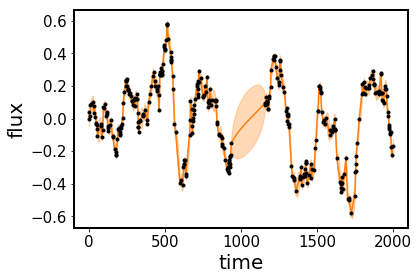

In [115]:
sigma_in = 0.2
tau_in = 100 
kernel = terms.RealTerm(log_a = 2 * np.log(sigma_in) , 
                        log_c = np.log(1/tau_in))
i=0
DirIn = '../raw_data/DRWtestCeleriteZI/'
files = os.listdir(DirIn)
lc = Table.read(DirIn +files[i], format='ascii', names=['time', 'mag', 'err'] )    

start, stop = 200, 250  
# the full observed array has 400 elements. .... 
# we remove some to simulate 'missing data window' ...

t,y,yerr = list(lc['time'][:start])+list(lc['time'][stop:]), \
    list(lc['mag'][:start])+list(lc['mag'][stop:]),\
    list(lc['err'][:start])+list(lc['err'][stop:])

    # call the model  with a chosen kernel instance 
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)

initial_params = gp.get_parameter_vector()

sigma_bounds = [0.001, 1.0]
tau_bounds = [1,10000]


use_bounds = True
prior = 'new'
#for use_bounds, prior in product([True], ['flat', 'exp', 'new']):    
if use_bounds : # use some custom boundaries 
    logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
    loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
    bounds = [loga_bounds, logc_bounds]
else : # use the built-in boundaries (-inf : +inf )
    bounds = gp.get_parameter_bounds()

if prior is 'flat' : 
    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y)

if prior is 'exp' :
    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        log_a = params[0]
        log_c = params[1]
        #log_sigma = log_a / 2.0 
        #log_tau = - log_c
        return -gp.log_likelihood(y)  -0.5* (log_c - log_a - np.log(2))

if prior is 'new' : 
    def neg_log_like(params,y,gp):
        gp.set_parameter_vector(params)
        log_a = params[0]
        log_c = params[1]
        log_sigma = log_a / 2.0 
        log_tau = - log_c
        sigma = np.exp(log_sigma)
        tau  = np.exp(log_tau)
        return -gp.log_likelihood(y) - np.log(1.0/sigma + 1.0/tau)

# do the scipy optimize to find the maximum likelihood estimator 
# for hyperparameters.... 
#print('Using %s prior'%prior)
r = minimize(neg_log_like, initial_params, 
             method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)

# retrieve the best-fit parameters 
res = gp.get_parameter_dict()
sigma_fit = np.exp(res['kernel:log_a']/2)
tau_fit = 1.0 / np.exp(res['kernel:log_c'])

# predict the (Gaussian) conditional (on the observed data) 
# distribution for new observations, to get the 
# estimate for standard deviation 

# where should we evaluate prediction ? 
# a) best at the same points at which we are providing hte 
# simulated dataset ... 
#  x = t

# b) at much denser sampling, so that we'll see that 
# the prediction becomes less certain when there is no
# data ... (note region around 1000...)
x = np.linspace(0, 2000, 5000) # t
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

# plot the prediction vs the observations.... 
color = "#ff7f0e"
#plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("time")
plt.ylabel("flux")
plt.savefig('DRW_missing_data_celerite_fit.png', bbox_inches='tight')


In [127]:
initial_params

array([-3.21887582, -4.60517019])

In [142]:
# To find the errors on the MLE sigma, tau, 
# we take the objective function - the neg_log_like , and : 
# 1) calculate the Hessian matrix   H
# 2) calculate the expectation at the minimum returned by the optimizer E[H]
# 3) take the inverse of the Information matrix  ( I = -E[H] ) to get variance 
# 4) take the square root of variance to get standard deviation 

# In the calculation below I follow loosely 
# http://rlhick.people.wm.edu/posts/estimating-custom-mle.html
import numdifftools as nd

def Wrap_neg_log_like(theta) : 
    return neg_log_like(theta, y, gp)

Hfun = nd.Hessian(Wrap_neg_log_like, full_output=True)
hessian_ndt, info = Hfun(r['x'])

# standard deviation is the square of variance
# note  : this error is the error on the 
# MLE of the log_c , log_a 
se = np.sqrt(np.diag(np.linalg.inv(hessian_ndt)))

# Note: 
#parameters : r['x']
#std err : se   ( error on  log_a,  log_c ... )

print(r['x'])

[-3.01711956 -4.78624275]


In [143]:
print(se)

[ 0.31755117  0.3244497 ]


In [149]:
# error from hessian on log_a, log_c
s_log_a = se[0]
s_log_c = se[1]

# these are natural logs
log_a = res['kernel:log_a']
log_c = res['kernel:log_c']

# convert to error on a, c  
s_a = s_log_a * np.exp(log_a)
s_c = s_log_c * np.exp(log_c)

# now a = sigma^2 ,  c = tau^{-1}
# convert to error on sigma, tau 

s_sigma = s_a / (2 * sigma_fit)
s_tau = s_c * tau_fit*tau_fit



# Compare Celerite to Chelsea <a id='compare'></a>

"I have attached the fits - the first four columns are:

1. The light curve filename
2. chi^2 of fit
3. log(tau) (in days)
4. log(sigma-hat) (in mag/sqrt(year))

The fit parameters are similar to your input, with: 

$<\tau>$ = 98.5 days 

$<\sigma> = < SF_{\infty} / \sqrt{2} > = 0.2 $ mag


The tau is more biased than sigma, since sigma-hat is well-constrained/not biased, while sigma goes as sqrt(tau).

By the way, the last column list the number of acceptable data points that went into the fit, and sometimes it is <400 because it rejects duplicate MJD values. 
"

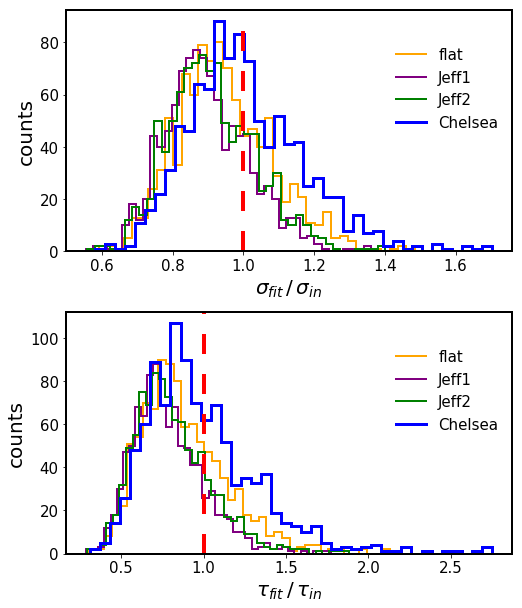

In [159]:
import matplotlib.lines as mlines
%matplotlib inline
# plot histograms : marginalize along either dimension ... 

fig ,ax  = plt.subplots(2,1,figsize=(8,10))

# two panels  : tau and sigma 
sigma_in = 0.2
tau_in = 100 

length = 20 
i = 0 
x0 = [0.2,0.62]


# Grab Chelsea' results ...
fits = Table.read(outDir+'fits.dat', format='ascii')
tau_fit = np.power(10,fits['col3'].data)
sigma_hat = np.power(10, fits['col4'].data)
sigma_fit = sigma_hat / np.sqrt(2 / (tau_fit/365.0)) 
# to convert to mag / sqrt(years)...

# Read the results from Celerite ...
simDir = '../data_products/Fig_Celerite_ZI_LC_fits/2017-10-27/'
results = np.load(simDir+'ZI_fits_results_11-02-17.npy').item()

# need to store lines for axis legends in an object 
ax_legend_handles = []

color_dict = {'Chelsea':'blue',  'flat':'orange',
             'Jeff1':'purple','Jeff2':'green' }

# results of Celerite with ZI light curves 
use_bounds  = True
for prior in priors: 
    x =  results[prior]['sigma_fit'] / sigma_in
    ax[0].hist(x, histtype='step', lw=2, bins=40, color=color_dict[prior])#
    line = mlines.Line2D([], [], color=color_dict[prior], lw=2, label=prior)
    ax_legend_handles.append(line)
    
    y = results[prior]['tau_fit'] / tau_in
    ax[1].hist(y,  histtype='step', lw=2, bins=40, color=color_dict[prior])
# NOTE :  need to make a line object to 
# avoid getting a legend with a box ... 
# https://matplotlib.org/users/legend_guide.html#plotting-guide-legend 
       
    
# results of Chelsea 
x =  sigma_fit / sigma_in
ax[0].hist(x,  histtype='step', lw=3, bins=40,color=color_dict['Chelsea'])    
line = mlines.Line2D([], [], color=color_dict['Chelsea'], lw=3, label='Chelsea')
ax_legend_handles.append(line)
    
y = tau_fit / tau_in
ax[1].hist(y, histtype='step', lw=3, bins=40,color=color_dict['Chelsea'])

ax[0].set_xlabel(r'$\sigma_{fit}\,/ \,\sigma_{in}$')
ax[1].set_xlabel(r'$\tau_{fit} \,/\, \tau_{in}$')

for i in [0,1]:
    ax[i].legend(loc='upper left', handles = ax_legend_handles, frameon=False,
                bbox_to_anchor=(0.71, 0.9), fontsize=15)
    ax[i].axvline(1, lw=4, ls='--', c='red', dashes=(5,5))
    ax[i].set_ylabel('counts')
    
    
fig.subplots_adjust(hspace=0.25)
#fig.suptitle('N = '+str(len(t))+', length = '+str(length)+  r'$ \tau_{in}$,'+' '\
#                 +str(len(x))+' fits' + '\n' \
#                 + 'err='+str(yerr[0])+' [mag], '+b, fontsize=20)
plt.savefig(outDir + 'sigma_tau_ratios_chelsea_celerite_1.png')
# in each panel , plot histogram of both 

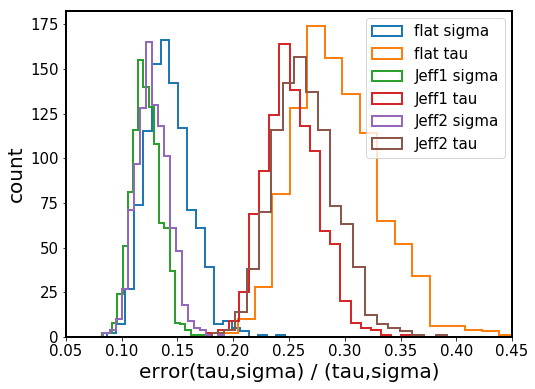

In [175]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
for prior in priors:
    for par in ['sigma','tau']:
        ax.hist(results[prior]['s_'+par]/results[prior][par+'_fit'], histtype='step',
                label = prior+' '+par,lw=2, bins=20)
plt.legend(fontsize=15)
ax.set_xlabel('error(tau,sigma) / (tau,sigma)')
ax.set_ylabel('count')
ax.set_xlim(0.05,0.45)
plt.savefig(outDir+'error_ratio_Celerite_1.png', bbox_inches='tight')

tau Jeff2


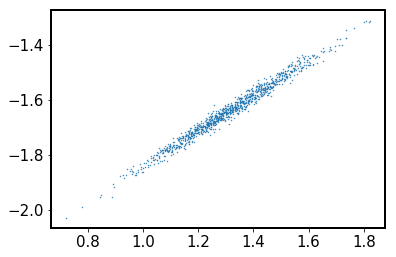

In [186]:
print(par, prior)
plt.scatter(np.log10(results[prior]['s_tau']), 
            np.log10(results[prior]['s_sigma']), s=0.2)

In [187]:
results

{'Jeff1': {'s_loga': array([ 0.27699086,  0.23176207,  0.27081422,  0.24464726,  0.23088132,
          0.2511194 ,  0.20161518,  0.25021784,  0.2683708 ,  0.27313308,
          0.23157982,  0.24731491,  0.26639818,  0.22468181,  0.28462851,
          0.24540067,  0.21383519,  0.22538722,  0.22749483,  0.2684687 ,
          0.2735269 ,  0.2395399 ,  0.23770825,  0.31476661,  0.2666191 ,
          0.24930612,  0.2653164 ,  0.25035388,  0.25362062,  0.25797819,
          0.26021059,  0.28150792,  0.23546013,  0.2123918 ,  0.25286829,
          0.23954643,  0.25376058,  0.19883118,  0.23804501,  0.27972271,
          0.23064552,  0.24287412,  0.26001239,  0.24389259,  0.2486893 ,
          0.20462146,  0.23645554,  0.28527523,  0.26410278,  0.21710512,
          0.25299941,  0.23248719,  0.23137289,  0.24882465,  0.27766591,
          0.27852217,  0.25736359,  0.2512399 ,  0.23095918,  0.21794672,
          0.23642757,  0.30621422,  0.26047583,  0.20547549,  0.2458717 ,
          0.2701670

## Save combined Celerite and Chelsea results <a id='save'></a>

In [177]:
# Make an AstroPy table from Celerite fit results 
celerite_fits = Table()
celerite_fits['name'] = files
for prior in priors : 
    for key in results[prior].keys():
        colname = prior + '-'+key
        celerite_fits[colname] = results[prior][key]
        
# Make an AstroPy table from Chelsea fit results        
fits = Table.read(outDir+'fits.dat', format='ascii')
chelsea_fits = Table()
chelsea_fits['name'] = fits['col1']
chelsea_fits['Chelsea-tau'] = np.power(10,fits['col3'].data)
sigma_hat = np.power(10, fits['col4'].data)
chelsea_fits['Chelsea_sigma']  = sigma_hat / np.sqrt(2 / (tau_fit/365.0))
#  to convert to mag / sqrt(years)...

# merge on name 
from astropy.table import join
combined = join(celerite_fits, chelsea_fits)

# save the result ...
combined.write('celerite_chelsea_fit_results1.txt', format='ascii')

In [178]:
plt.scatter()

name,flat-sigma_fit,flat-tau_fit,flat-s_sigma,flat-s_tau,flat-s_loga,flat-s_logc,Jeff1-sigma_fit,Jeff1-tau_fit,Jeff1-s_sigma,Jeff1-s_tau,Jeff1-s_loga,Jeff1-s_logc,Jeff2-sigma_fit,Jeff2-tau_fit,Jeff2-s_sigma,Jeff2-s_tau,Jeff2-s_loga,Jeff2-s_logc,Chelsea-tau,Chelsea_sigma
str28,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
DRWtestCeleriteZI_LC1.dat,0.176037565519,78.4694407039,0.0240474969305,22.122191961,0.273208696787,0.281921111742,0.167741381798,70.9100892648,0.0199533841548,17.4620204729,0.237906519439,0.246255795951,0.170203324089,73.1831863702,0.0211025714825,18.7648229608,0.247968970001,0.256408936144,85.033489209,0.184298402149
DRWtestCeleriteZI_LC10.dat,0.154673661316,55.9539718856,0.0180696415744,13.6505601649,0.23364859176,0.243960521565,0.149130311193,51.7603120556,0.0156781290695,11.400158652,0.210260797341,0.220249032497,0.150817700449,53.0711788846,0.0163790301644,12.0615618503,0.217203022133,0.22727141367,58.9521977065,0.159922499866
DRWtestCeleriteZI_LC100.dat,0.175969903008,79.6282230351,0.02464835665,23.0410774616,0.280142867942,0.28935817708,0.167299863465,71.6140562774,0.0202779642458,17.9924995886,0.24241459408,0.251242570578,0.16986509365,74.0118867933,0.0214968174452,19.3932225809,0.253104590041,0.262028485169,87.0943535509,0.18494584119
DRWtestCeleriteZI_LC1000.dat,0.170364634904,73.0396082473,0.0222728506561,19.7344226867,0.261472701404,0.270187959112,0.162929253851,66.4929626495,0.0187415869257,15.8543531673,0.230057972805,0.238436558329,0.165156445895,68.4862640334,0.0197474772113,16.9571660327,0.23913662109,0.247599518999,79.5572934599,0.178839550627
DRWtestCeleriteZI_LC101.dat,0.179882454491,75.3606041056,0.0239647410531,20.7251359911,0.266448899877,0.275012869617,0.171761349631,68.3925073886,0.020062076028,16.540405311,0.233604079975,0.241845283096,0.174184915024,70.5036309881,0.0211671367421,17.7219581733,0.24304213415,0.251362347229,81.635677248,0.188626006402
DRWtestCeleriteZI_LC102.dat,0.179676105186,79.4552531644,0.0245507913815,22.3787915272,0.273278312174,0.281652762227,0.171207330591,71.8093950673,0.0203775254674,17.6705967645,0.238045011239,0.246076390811,0.173721345637,74.1091157822,0.0215494424528,18.9873913337,0.248092050793,0.256208580189,85.5775797727,0.187767130761
DRWtestCeleriteZI_LC103.dat,0.23942871986,134.151921736,0.0418125357348,47.7499043646,0.349269175054,0.355939026043,0.222446781427,115.273783475,0.0316573482892,33.5358748765,0.284628512816,0.29092369371,0.227228394141,120.559167262,0.0342713814733,37.1358980975,0.301646997972,0.30803047948,155.560739852,0.259865466477
DRWtestCeleriteZI_LC104.dat,0.205950695932,103.480796153,0.0326676192344,33.6816385212,0.317237279405,0.325486851409,0.193447233912,90.8431613797,0.0257137685516,24.862533365,0.265847880392,0.273686351151,0.197051983528,94.492647272,0.0275723824803,27.1937382457,0.27984881945,0.287786817607,113.333943374,0.217125369205
DRWtestCeleriteZI_LC105.dat,0.184128008636,78.0195612948,0.0250156406419,21.8725838883,0.271720101978,0.280347434994,0.175528756149,70.569394336,0.0207990911525,17.3083788131,0.236987848701,0.245267498409,0.17808706757,72.8161323209,0.0219864557871,18.5887904565,0.246918050673,0.255283957882,84.8457318317,0.193445918024
